Imports

In [246]:
import numpy as np
import torch
from torchvision import datasets
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

Auxiliary Functions

In [247]:
# Auxiliary Functions

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
  e_x = torch.exp(x - torch.max(x, dim=1, keepdim=True).values)
  return e_x / torch.sum(e_x, dim=1, keepdim=True)

def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Label axes
    ax.set(
        xticks=np.arange(len(class_names)),
        yticks=np.arange(len(class_names)),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel='True label',
        xlabel='Predicted label',
        title='Confusion Matrix'
    )

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add text labels inside the cells
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

    fig.tight_layout()
    plt.show()


Manual Logistic Regression Implementation

In [248]:
class ManualLogisticRegression:
    def __init__(self, learning_rate = 1e-3, max_epochs=1000, tolerance = 1e-4, lambda_reg= 1e-3, patience=10):
        self.max_epochs = max_epochs
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None
        self.train_loss_history = []
        self.val_loss_history = []
        self.tolerance = tolerance
        self.lambda_reg = lambda_reg
        self.patience = patience

    def loss_function(self, y_true, y_pred, x):
        epsilon = 1e-10
        cce = -torch.mean(torch.sum(y_true * torch.log(y_pred + epsilon), dim=1))

        # L2 Regularization:
        l2_term = torch.sum(self.weights ** 2) * (self.lambda_reg/(2 * x.shape[0]))
        return cce + l2_term 


    def fit(self, x, y, x_val=None, y_val=None):
        # Initialize weights and bias:
        n_classes = 10
        image_size = 28 * 28
        self.weights = torch.randn(image_size, n_classes, requires_grad=True) * 0.01
        self.bias = torch.zeros(1, 10, requires_grad=True)

        self.train_loss_history = []
        self.val_loss_history = []

        epochs_wo_improvement = 0
        # Train
        for epoch in range(self.max_epochs): #tqdm(range(self.max_epochs)):

            # if self.weights.grad is not None and self.bias.grad is not None:
            #     self.weights.grad.zero_()
            #     self.bias.grad.zero_()
            # Forward
            z = x @ self.weights + self.bias
            y_pred = softmax(z)

            loss = self.loss_function(y_true=y, y_pred=y_pred, x=x)
            self.train_loss_history.append(loss.detach())

            # Backward
            y_pred_val = 0

            with torch.no_grad():
                if x_val is not None and y_val is not None:
                    y_pred_val = x_val @ self.weights + self.bias
                    y_pred_val = torch.softmax(y_pred_val, dim=1)
                    val_loss = self.loss_function(y_true=y_val, y_pred=y_pred_val, x=x_val)
                    self.val_loss_history.append(val_loss.detach())

                dz = y_pred - y
                dW = (1 / x.shape[0]) * torch.matmul(x.T, dz) + (self.lambda_reg / x.shape[0]) * self.weights
                db = (1 / x.shape[0]) * torch.sum(dz, dim=0, keepdim=True)

                # Parameter update with traditional Gradient Descent
                self.weights -= self.learning_rate * dW
                self.bias -= self.learning_rate * db

            if epoch % int((self.max_epochs - 1)) == 0:
                print(f"Epoch {epoch} | Training Loss = {loss:.4f} | Val/Test Loss: {val_loss:.4f} | L2 Term: {torch.sum(self.weights ** 2) * 0.5}")
            
            # Early stopping (with gradient analysis and loss analysis)
            if (torch.norm(dW) < self.tolerance and torch.norm(db) < self.tolerance):
                print(f"Convergiu após {epoch + 1} iterações")
                print(f"Epoch {epoch} | Training Loss = {loss:.4f} | Val/Test Loss: {val_loss:.4f} | L2 Term: {torch.sum(self.weights ** 2) * 0.5}")
                break
    
    def predict(self, x):
        with torch.no_grad():
            y_pred = x @ self.weights + self.bias
            y_pred = torch.softmax(y_pred, dim=1)
            return torch.argmax(y_pred, dim=1)
    
    def evaluate(self, x_true, y_true_labels):
        with torch.no_grad():
            y_pred_labels = self.predict(x=x_true)
            print(f"Accuracy: {accuracy_score(y_true_labels, y_pred_labels):.4f}")
            # cm = confusion_matrix(y_true_labels, y_pred_labels)
            # plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])
            return accuracy_score(y_true_labels, y_pred_labels)

                     

In [249]:
train_data = datasets.MNIST('./datasets', train=True)
test_data = datasets.MNIST('./datasets', train=False)

x_train = train_data.data.float().reshape(-1, 28 * 28) / 255.0
y_train_labels = train_data.targets

# one-hot encoding with 10 classes
y_train = torch.zeros(len(y_train_labels), 10)
y_train[torch.arange(len(y_train_labels)), y_train_labels] = 1

x_test = test_data.data.float().reshape(-1, 28 * 28) / 255.0
y_test_labels = test_data.targets
y_test = torch.zeros(len(y_test_labels), 10)
y_test[torch.arange(len(y_test_labels)), y_test_labels] = 1 


Dataset pre-processing

In [250]:
mean = x_train.mean()
std = x_train.std()

x_train = (x_train - mean)/ std
x_test = (x_test - mean)/ std

K-Fold CV

---------------------------------------
Learning rate: 0.01
Epoch 0 | Training Loss = 2.3602 | Val/Test Loss: 2.3639 | L2 Term: 0.39662179350852966
Epoch 999 | Training Loss = 0.3431 | Val/Test Loss: 0.3404 | L2 Term: 2.802518844604492
Accuracy: 0.9050


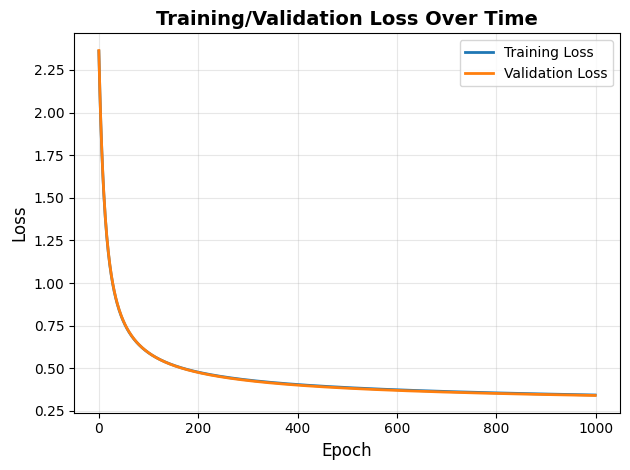

Epoch 0 | Training Loss = 2.3722 | Val/Test Loss: 2.3721 | L2 Term: 0.3928622305393219
Epoch 999 | Training Loss = 0.3365 | Val/Test Loss: 0.3515 | L2 Term: 2.8326501846313477
Accuracy: 0.9000


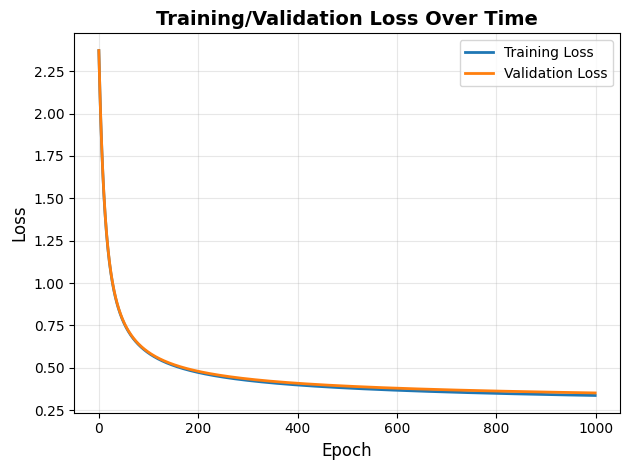

Epoch 0 | Training Loss = 2.4006 | Val/Test Loss: 2.4028 | L2 Term: 0.3945075273513794


In [ ]:
# each pixel has a weight associated with it. Initially, the weights need to be initialized

# size is the list size inside the weight matrix, it includes the weight of every pixel. Since there are 10 different possible labels, we will have 10 perceptrons
max_iter = 1000
learning_rate = 0.01
tolerance = 1e-3
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)


best_results = [0, 0]


logreg = ManualLogisticRegression(learning_rate=learning_rate, max_epochs=max_iter, tolerance=tolerance)
print("---------------------------------------")
print(f"Learning rate: {learning_rate}")
kfold_accuracies = [] 

for fold, (train_index, validation_index) in enumerate(kf.split(x_train)):
  logreg.weights = torch.randn(28 * 28, 10, requires_grad=True) * 0.01
  logreg.bias = torch.zeros(28 * 28)
  logreg.train_loss_history = []
  logreg.val_loss_history = []

  x_train_fold = x_train[train_index]
  y_train_fold = y_train[train_index]
  x_val_fold = x_train[validation_index]
  y_val_fold = y_train[validation_index]

  logreg.fit(x=x_train_fold, y=y_train_fold, x_val=x_val_fold, y_val=y_val_fold)

  y_val_fold_labels = torch.argmax(y_val_fold, dim=1)
  accuracy = logreg.evaluate(x_true=x_val_fold, y_true_labels=y_val_fold_labels)
  kfold_accuracies.append(accuracy)



  # final_f1 = f1_score(y_true=y_test_labels, y_pred=y_pred_labels, average='weighted')


  plt.plot(logreg.train_loss_history, linewidth=2, label='Training Loss')
  plt.plot(logreg.val_loss_history, linewidth=2, label='Validation Loss')
  # plt.plot(logreg.test_loss_history, linewidth=2)
  plt.title('Training/Validation Loss Over Time', fontsize=14, fontweight='bold')
  plt.xlabel('Epoch', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.grid(True, alpha=0.3)
  plt.legend()
  plt.tight_layout()
  plt.show()
avg = torch.mean(torch.tensor(kfold_accuracies))
if best_results[0] < avg:
  best_results[0] = avg
  best_results[1] = learning_rate
  
print(f"Best average accuracy: {best_results[0]} | learning_rate: {best_results[1]}")


Final Re-Training

Epoch 0 | Training Loss = 2.3224 | Val/Test Loss: 2.3208 | L2 Term: 0.39357349276542664
Convergiu após 10 iterações
Epoch 9 | Training Loss = 1.5662 | Val/Test Loss: 1.5503 | L2 Term: 0.42361992597579956


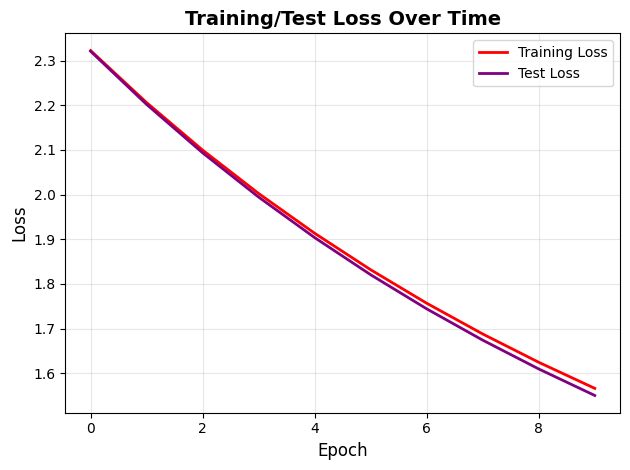

In [ ]:
# each pixel has a weight associated with it. Initially, the weights need to be initialized
# size is the list size inside the weight matrix, it includes the weight of every pixel. Since there are 10 different possible labels, we will have 10 perceptrons
max_iter = 10000
logreg = ManualLogisticRegression(learning_rate=learning_rate, max_epochs=max_iter, tolerance=tolerance)
logreg.fit(x=x_train, y=y_train, x_val=x_test, y_val=y_test)

plt.plot(logreg.train_loss_history, linewidth=2, color='red', label='Training Loss')
plt.plot(logreg.val_loss_history, linewidth=2, color='purple', label='Test Loss')
plt.title('Training/Test Loss Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

Testagem do modelo

Accuracy: 0.1016
Test Accuracy: 0.1016
Test F1-Score: 0.09018250966036961
Total Epochs: 10


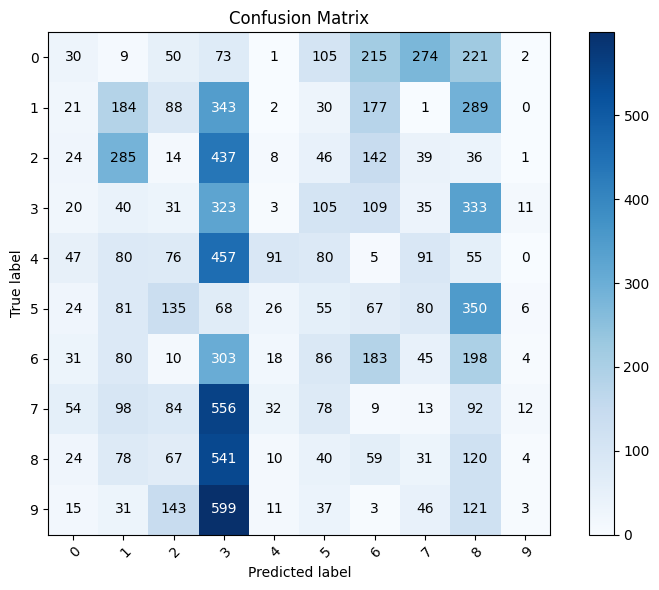

In [ ]:
logreg.evaluate(x_true=x_test, y_true_labels=y_test_labels)

y_pred_labels = logreg.predict(x_test)


final_accuracy = accuracy_score(y_true=y_test_labels, y_pred=y_pred_labels)
final_f1 = f1_score(y_true=y_test_labels, y_pred=y_pred_labels, average='weighted')
print(f"Test Accuracy: {final_accuracy}")
print(f"Test F1-Score: {final_f1}")
print(f"Total Epochs: {len(logreg.val_loss_history)}")

cm = confusion_matrix(y_test_labels, y_pred_labels)
plot_confusion_matrix(cm, class_names=[str(i) for i in range(10)])
